# Проект - "Мэтчинг товаров"

Задача:

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;<br/>
- оценить качество алгоритма по метрике accuracy@5.<br/><br/>

Контакты для связи: https://t.me/anbegunov<br/>
Бегунов Андрей

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import faiss

import matplotlib.pyplot as plt
from importlib import reload

In [2]:
# отключаю ограничение на вывод, т.к. много признаков
pd.set_option('display.max_rows', None)

In [3]:
# воспользовался советом https://stackoverflow.com/questions/65172029/why-do-i-get-str-object-is-not-callable
# т.к. plt не выводил метки
plt=reload(plt)

# Подготовка данных

In [4]:
df = pd.read_csv('base.csv', index_col=0)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


Все признаки имеют тип данных float. Конвертировать типы не нужно.

Проверим на пропуски.

In [6]:
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
dtype: int64

Пропусков не обнаружено.

Посмотрим на распределение данных.

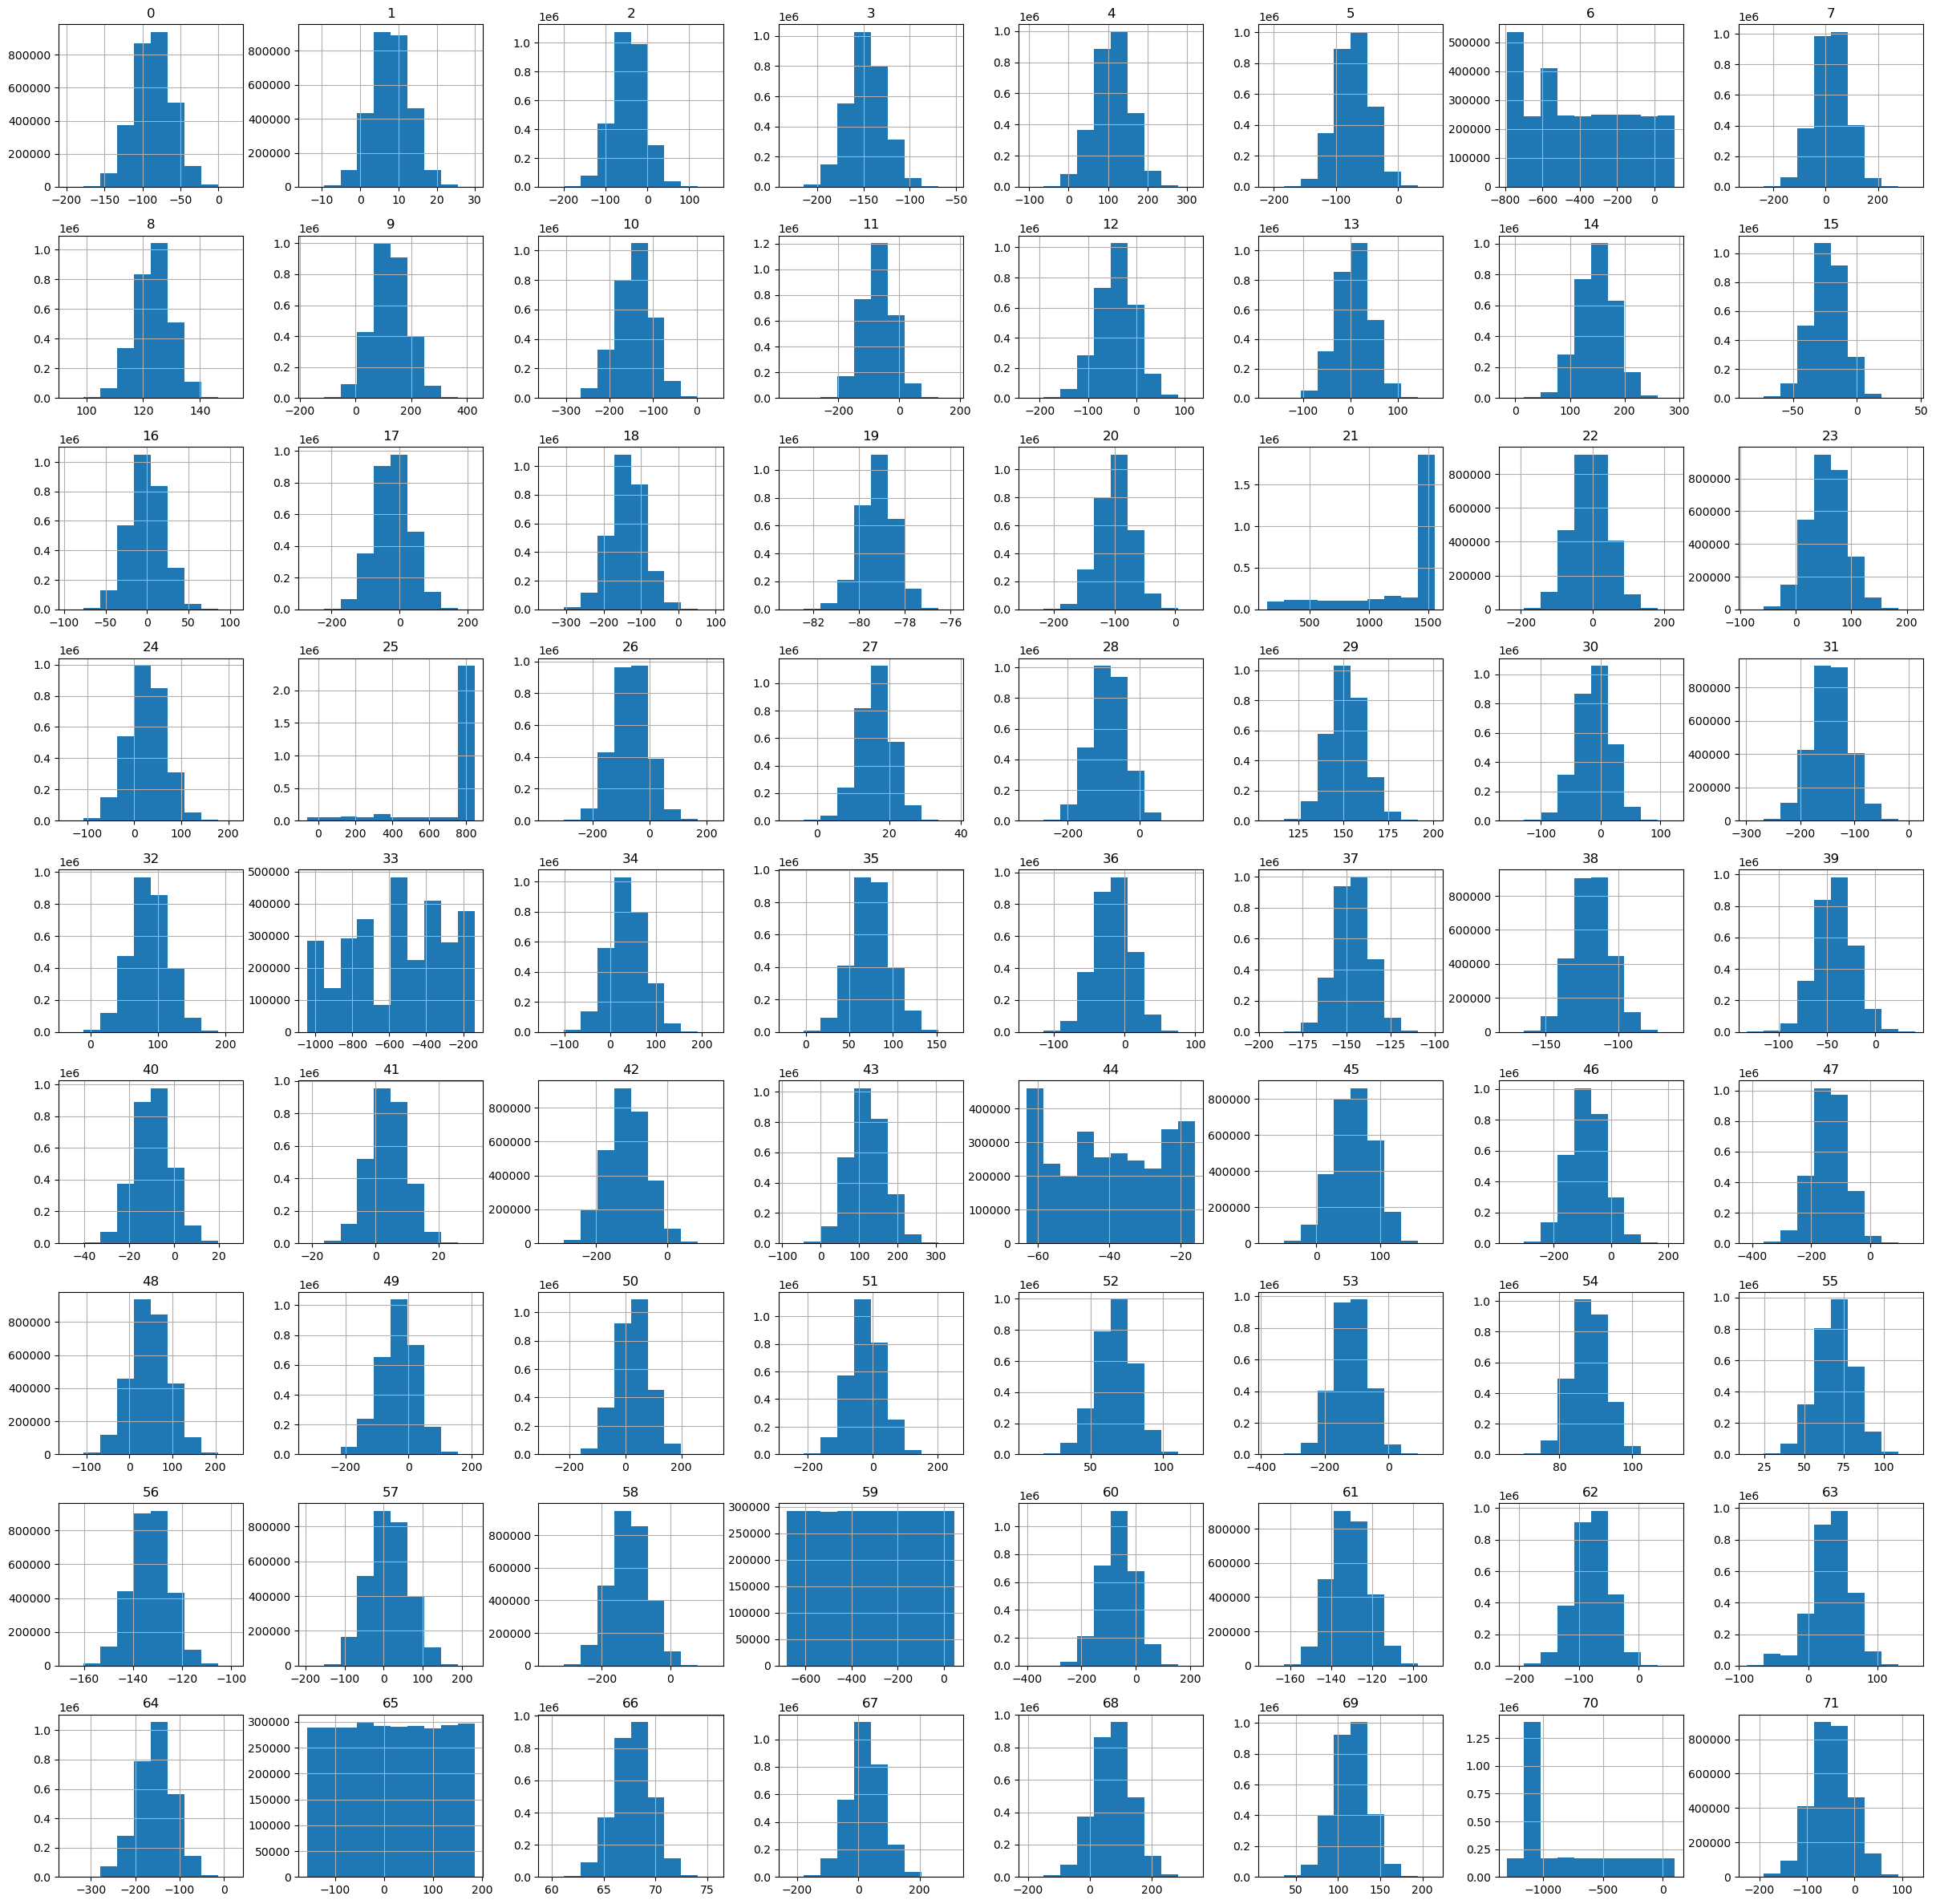

In [7]:
df.hist(figsize=(30,30));

Большинство признаков имеют либо нормальное, либо равномерное распределение. Есть несколько всплесков, но т.к. мы не знаем характер данных - оставляем как есть.

Посмотрим данные в остальных файлах.

In [8]:
df_train = pd.read_csv('train.csv')
df_train.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [9]:
df_valid = pd.read_csv('validation.csv')
df_valid.head(5)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [10]:
df_valid_target = pd.read_csv('validation_answer.csv')
df_valid_target.head(5)

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Никаких аномалий не обнаружено. Можно приступать к подготовке признаков. 

In [11]:
features = df

In [12]:
features_train = df_train.drop(['Id', 'Target'], axis=1)
target_train = df_train['Target'].values.tolist()

In [13]:
features_valid = df_valid.drop(['Id'], axis=1)
target_valid = df_valid_target['Expected'].values.tolist()

**Резюме**<br/>
Аномалий в данных не обнаружено. Признаки готовы обработке.

# Масштабирование признаков

In [14]:
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns = features.columns, index = features.index)
features_train_scaled = \
    pd.DataFrame(scaler.transform(features_train), columns = features_train.columns, index = features_train.index)
features_valid_scaled = \
    pd.DataFrame(scaler.transform(features_valid), columns = features_valid.columns, index = features_valid.index)

# Подбор алгоритма метчинга

Для начала проверим связку Kmeans + KNN <br/>
Необходимо подобрать оптимальное количество кластеров методом локтя по inertia и анализом индекса Девиса Болдина.<br/>
Чтобы не тратить много времени - возьмем 10% от всей выборки.

In [15]:
sample_features_scaled = features_scaled.sample(frac=0.1, random_state=12345)

Для скорости анализ будем проводить на интервале до 200 кластеров через каждые 10.

In [16]:
%%time
inertia_score = []
db_score = []
#Начнем с 2, потому что Девису Болдину нужно минимум 2. Т.к. счет кластеров на десятки, не принципиально
max_n_clusters = range(2, 202, 10) 
for n in max_n_clusters:
    kmeans = KMeans(n_clusters=n, n_init="auto", random_state=12345)
    kmeans.fit(sample_features_scaled)
    inertia_score.append(kmeans.inertia_)
    labels = kmeans.labels_
    db = davies_bouldin_score(sample_features_scaled, labels)
    db_score.append(db)

CPU times: total: 17min 21s
Wall time: 2min 20s


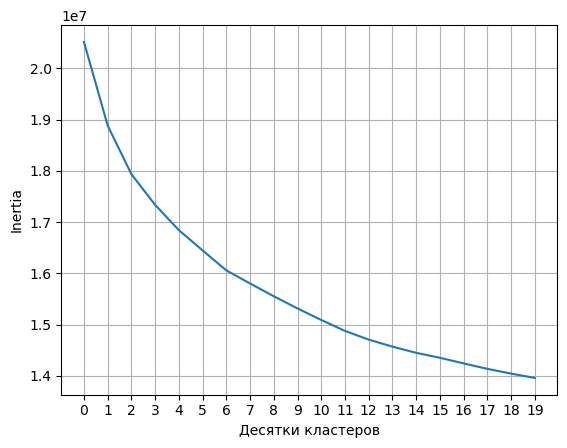

In [17]:
plt.plot(inertia_score)
plt.xlabel("Десятки кластеров")
plt.ylabel('Inertia')
plt.grid()
plt.xticks(np.arange(0, 20, step=1))
plt.show();

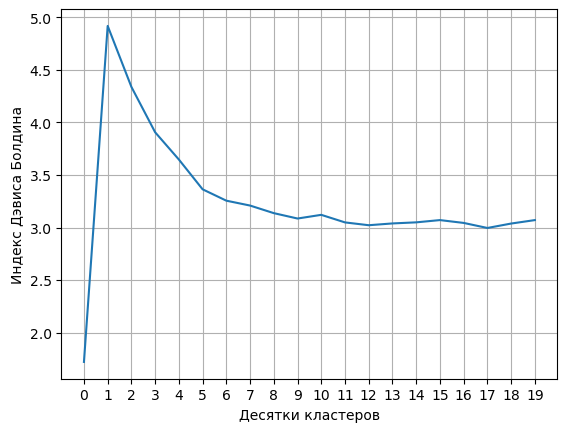

In [18]:
plt.plot(db_score)
plt.xlabel("Десятки кластеров")
plt.ylabel('Индекс Дэвиса Болдина')
plt.grid()
plt.xticks(np.arange(0, 20, step=1))
plt.show();

График индекса Девиса Болдина более четко выражен, чем метрика inertia, но в целом показатели совпадают.<br/>
Для анализа возьмем первый локальный минимум в 90 кластеров и второй в 120.<br/>
Можно будет сравнить, как количество кластеров влияет на время поиска и на метрику качества.<br/>
Т.к. разброс между количеством кластеров достаточно высок - на текущем этапе не вижу смысла повышать точность анализа. Пока можно обойтись десятками. Если разброс по времени и показателям точности будет существенный - можно уже более точно подбирать количество кластеров.

In [19]:
n_clusters = 90

In [20]:
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=12345)
features_scaled['cluster'] = kmeans.fit_predict(features_scaled)

Посмотрим как данные распределены по кластерам.

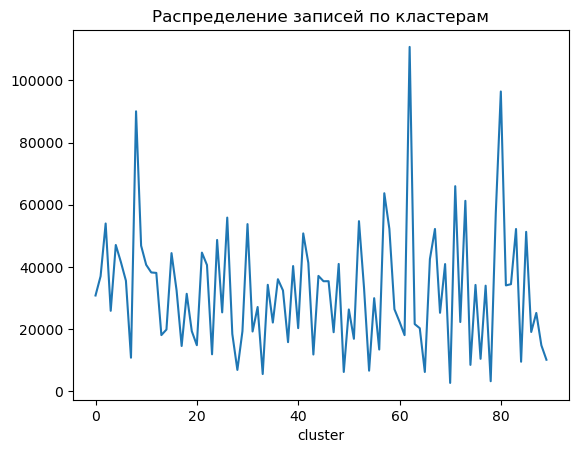

In [21]:
features_scaled.groupby(by=['cluster'])['0'].count().plot(title="Распределение записей по кластерам");

Есть небольшие пики, но это некритично. То же самое сделаем для 120 кластеров.

In [22]:
features_scaled = features_scaled.drop(['cluster'], axis=1)

In [23]:
n_clusters = 120

In [24]:
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=12345)
features_scaled['cluster'] = kmeans.fit_predict(features_scaled)

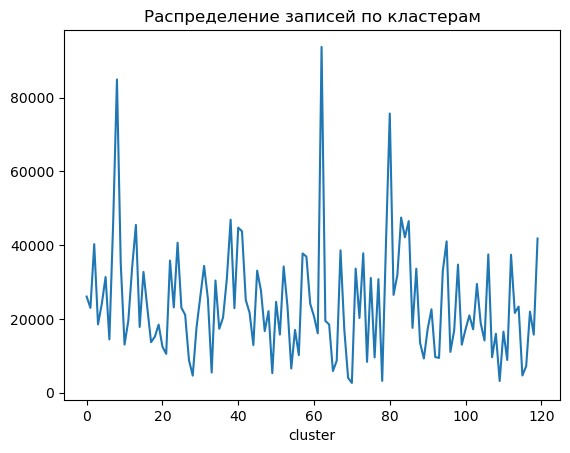

In [25]:
features_scaled.groupby(by=['cluster'])['0'].count().plot(title="Распределение записей по кластерам");

Картинка похожая, ожидаемо в кластерах меньше данных, должно положительно повлиять на скорость.

In [26]:
features_scaled = features_scaled.drop(['cluster'], axis=1)

Для удобства структуры кода размещу рядом функции рассчета kmeans + knn и faiss.

In [27]:
def calc_kmeans_knn(features, features_valid, n_clusters):
    result = np.empty(features_valid.shape[0], dtype=object)
    
    # kmeans рассчитываю повторно, чтобы посчитать время на весь алгоритм в одном месте
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=12345)
    features['cluster'] = kmeans.fit_predict(features)
    features_valid['cluster'] = kmeans.predict(features_valid)
    
    for i in range(0, n_clusters):
        features_cluster = features[features['cluster'] == i]
        features_valid_cluster = features_valid[features_valid['cluster'] == i]
        if len(features_valid_cluster) == 0:
            continue
        features_cluster = features_cluster.drop(['cluster'], axis=1)
        features_valid_cluster = features_valid_cluster.drop(['cluster'], axis=1)
    
        nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
        nbrs.fit(features_cluster)
        indices = nbrs.kneighbors(features_valid_cluster, return_distance=False)
        
        for index, values in enumerate(indices):
            result[features_valid_cluster.index[index]] = [features_cluster.index[v] for v in values]

    features.drop(['cluster'], axis=1, inplace=True)
    features_valid.drop(['cluster'], axis=1, inplace=True)  
    return result

In [28]:
def calc_faiss(features, features_valid):
    result = np.empty(features_valid.shape[0], dtype=object)
    
    dimension_count = features.shape[1]
    index = faiss.IndexFlatL2(dimension_count)
    index.add(features)
    
    d, indices = index.search(features_valid, 5)  
        
    for index, values in enumerate(indices):
        result[features_valid.index[index]] = [features.index[v] for v in values]
    return result

In [29]:
def accuracy5(target, target_test):
    acc = 0
    for value, nearest in zip(target, target_test):
        acc += int(value in nearest)
    return 100 * acc / len(target)

Запустим последовательно kmeans + knn для 90 и 120 кластеров.

In [30]:
%%time
kmeans90_target = calc_kmeans_knn(features_scaled, features_train_scaled, 90)

CPU times: total: 15min 5s
Wall time: 10min 51s


In [31]:
%%time
kmeans120_target = calc_kmeans_knn(features_scaled, features_train_scaled, 120)

CPU times: total: 20min 44s
Wall time: 9min 1s


Ожидаемо, при увеличении количества кластеров - время поиска сокращается.

Запустим поиск с помощью faiss.

In [32]:
%%time
faiss_target = calc_faiss(features_scaled, features_train_scaled)

CPU times: total: 31min 12s
Wall time: 4min 15s


Время сократилось более чем в 2 раза - это существенно.<br/>
Теперь посмотрим на значения метрики accurecy@5:

In [33]:
accuracy5(target_train, kmeans90_target)

55.598

In [34]:
accuracy5(target_train, kmeans120_target)

55.748

При разбиении выборки на 120 кластеров - получилось добится боле высоких показателей accuracy@5, но все-таки незначительно. Нет смысла более тщательно подбирать количество кластеров.

In [35]:
accuracy5(target_train, faiss_target)

65.838

А вот даже простейший индекс L2 на faiss дает значение метрики accurecy@5 на 10 единиц больше.<br/>
Подобъем результаты в таблицу.

<table>
    <thead>
        <tr>
            <th>Метод</th>
            <th>Accuracy@5</th>
            <th>Время выполнения</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Kmeans 90 + KNN</td>
            <td>55.598</td>
            <td>10min 51s</td>
        </tr>
        <tr>
            <td>Kmeans 120 + KNN</td>
            <td>55.748</td>
            <td>9min 1s</td>
        </tr>
        <tr>
            <td>FAISS</td>
            <td>65.838</td>
            <td>4min 20s</td>
        </tr>
    </tbody>
</table>

**Резюме**
Со значительным отрывом faiss-l2 лидирует в метрике accuracy@5, и работает в 2 раза быстрее, чем kmeans+knn.<br/>
Его мы и выбираем в качестве оптимального.<br/>
На следующем этапе необходимо проверить алгоритм faiss на валидационной выборке.

# Валидация модели кластеризации

In [36]:
%%time
faiss_target = calc_faiss(features_scaled, features_valid_scaled)

CPU times: total: 31min 21s
Wall time: 4min 15s


In [37]:
accuracy5(target_valid, faiss_target)

65.658

**Резюме**<br/>
Проверка на валидационной выборке полностью подтверждает выводы, сделанные на этапе анализа алгоритмов:<br/>
показатель accuracy@5 в районе 65 единиц, и время анализа около 4минут.

# Вывод

Я провел исследование алгоритмов метчинга данных и решил задачу разработки алгоритма поиска похожит товаров для validation.csv из base.csv.<br/>
Перед анализом я проверил входные данные и не обнаружил никаких аномалий.<br/><br/>

По совету наставника чтобы оценить пользу от алгоритмов кластериации, вначле я просто воспользовался методом knn для каждой записи из train по base. В итоге время обсчета составило 10h 53min 36s.<br/>
Данный рассчет я из исследования удалил, потому что работать с ним было не удобно.<br/><br/>

Чтобы ускорить алгоритм необходимо было взять алгоритм кластеризации, и я выбрал kmeans.<br/>
Для поиска оптимального количества кластеров - я решил построить построить графики метрики inertia и индекс Девиса Болдина - для каждого 10 кластера.<br/>
В качестве первого локального минимума выбрал 90 кластеров, в качестве второго - 120 кластеров.<br/>
После 120 кластеров - графики меняются незначительно, нет смысла увеличивать количество кластеров.<br/>
По графикам можно было сделать предположение, что значение метрики accuracy@5 для 120 кластеров будет выше, и время обсчета должно было получится меньше. Эта гипотеза впоследствии подтвердилась.<br/>
Мне удалось достигнуть показателя accuracy@5 в 55.748 за 9min 1s.<br/><br/>

После этого я проверил работу алгоритма faiss с индексом L2. Поулчил результат accuracy@5 в 65.838 за 4min 20s.<br/>
faiss - безоговорочный лидер.<br/>
Проверка на валидационное выборе подтвердила успешность выдвинутой гипотезы.<br/>

В итоге исследование считаю состоявшимся. Получилось выбрать оптимальынй алгоритм, с хорошими показателями accuracy@5 за приемлемое время.

